Training data shape: torch.Size([5182, 336, 42])
Test data shape: torch.Size([576, 336, 42])
Epoch [1/50], Total Loss: 0.594913, Quantile Loss: 0.187855, MSE Loss: 0.036772
Epoch [2/50], Total Loss: 0.414203, Quantile Loss: 0.178787, MSE Loss: 0.023721
Epoch [3/50], Total Loss: 0.389334, Quantile Loss: 0.174885, MSE Loss: 0.018854
Epoch [4/50], Total Loss: 0.383404, Quantile Loss: 0.158577, MSE Loss: 0.016728
Epoch [5/50], Total Loss: 0.377001, Quantile Loss: 0.151046, MSE Loss: 0.010698
Epoch [6/50], Total Loss: 0.372449, Quantile Loss: 0.141885, MSE Loss: 0.006950
Epoch [7/50], Total Loss: 0.369605, Quantile Loss: 0.183656, MSE Loss: 0.010885
Epoch [8/50], Total Loss: 0.368080, Quantile Loss: 0.137548, MSE Loss: 0.006150
Epoch [9/50], Total Loss: 0.366406, Quantile Loss: 0.209678, MSE Loss: 0.005904
Epoch [10/50], Total Loss: 0.365355, Quantile Loss: 0.170837, MSE Loss: 0.005411
Epoch [11/50], Total Loss: 0.362745, Quantile Loss: 0.155065, MSE Loss: 0.004842
Epoch [12/50], Total Loss

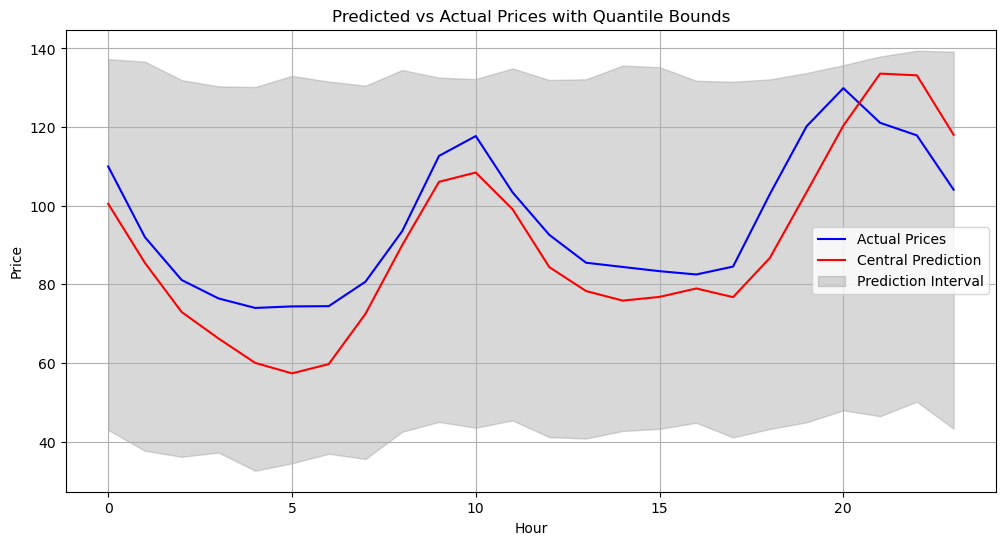

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# File paths
file_path = '../formatted_data/formatted_data.csv'

# Define input and output sequence lengths
sequence_length = 336  # Use 2 weeks of history
output_sequence_length = 24  # Predict the next 24 hours
batch_size = 32
test_split_ratio = 0.1

# Load the data
data = pd.read_csv(file_path)

start_date = "2023-01-01"
end_date = "2024-06-30"

# Convert to datetime for filtering
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

# Drop the `Date` column after filtering (if not needed further)
data = data.drop(columns=['Date'])

# Define feature columns (excluding time-based features)
weather_columns = [
    'Price_EUR_MWh', 'Volume_MWh', 'ID',
    'Andalusia (Wind)_temperature', 'Andalusia (Wind)_wind_u_component', 'Andalusia (Wind)_wind_v_component',
    'Aragon (Wind)_temperature', 'Aragon (Wind)_wind_u_component', 'Aragon (Wind)_wind_v_component',
    'Barcelona_temperature', 'Barcelona_wind_u_component', 'Barcelona_wind_v_component',
    'Bilbao_temperature', 'Bilbao_wind_u_component', 'Bilbao_wind_v_component',
    'Castile-La Mancha (Wind)_temperature', 'Castile-La Mancha (Wind)_wind_u_component', 'Castile-La Mancha (Wind)_wind_v_component',
    'Escatrón-Chiprana-Samper (Solar)_temperature', 'Escatrón-Chiprana-Samper (Solar)_wind_u_component', 'Escatrón-Chiprana-Samper (Solar)_wind_v_component',
    'Madrid_temperature', 'Madrid_wind_u_component', 'Madrid_wind_v_component',
    'Seville_temperature', 'Seville_wind_u_component', 'Seville_wind_v_component',
    'Talasol Solar (Solar)_temperature', 'Talasol Solar (Solar)_wind_u_component', 'Talasol Solar (Solar)_wind_v_component',
    'Talayuela Solar (Solar)_temperature', 'Talayuela Solar (Solar)_wind_u_component', 'Talayuela Solar (Solar)_wind_v_component',
    'Valencia_temperature', 'Valencia_wind_u_component', 'Valencia_wind_v_component'
]
time_columns = ['Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos']
target_column = 'DA'

data[weather_columns] = data[weather_columns].shift(-24) 

# Drop rows with missing values
data = data.dropna(subset=weather_columns + [target_column])

# Initialize scalers
scaler_weather = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

# Fit scalers on weather features and target column
weather_scaled = scaler_weather.fit_transform(data[weather_columns])
target_scaled = scaler_target.fit_transform(data[[target_column]])

# Concatenate scaled weather and unscaled time features
features_scaled = np.hstack([weather_scaled, data[time_columns].values])

# Prepare data for sequences
X = []
y = []

for i in range(len(features_scaled) - sequence_length - output_sequence_length):
    X.append(features_scaled[i:i + sequence_length])  # Input sequence
    y.append(target_scaled[i + sequence_length:i + sequence_length + output_sequence_length].flatten())  # Target sequence

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Train-test split
split_idx = int(len(X) * (1 - test_split_ratio))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Define LSTM model with quantiles
class LSTMModelWithQuantiles(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, quantiles, num_layers=2, dropout=0.2):
        super(LSTMModelWithQuantiles, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.central_fc = nn.Linear(hidden_size, output_size)  # Fully connected for central prediction

        # Separate MLP heads for quantile predictions
        self.quantile_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, output_size)
            )
            for _ in quantiles
        ])

        self.quantiles = quantiles  # List of quantiles

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        context = lstm_out[:, -1, :]  # Last timestep output

        central_output = self.central_fc(context)  # Central prediction
        quantile_outputs = [head(context) for head in self.quantile_heads]  # Quantile predictions

        return central_output, quantile_outputs

def quantile_loss_with_precision(y_true, y_pred, quantiles, reg_factor=0.01, target_coverage=None, lambda_coverage=0.0, precision_penalty=0.1):
    """
    Quantile loss function with precision reward/penalty.

    Args:
        y_true: Ground truth values [batch_size, forecast_horizon].
        y_pred: Predicted quantiles [batch_size, num_quantiles, forecast_horizon].
        quantiles: List of quantiles used for prediction.
        reg_factor: Regularization factor to penalize overly wide intervals.
        target_coverage: Desired coverage percentage (e.g., 80%).
        lambda_coverage: Weight for coverage penalty.
        precision_penalty: Weight for penalizing wide bounds far from actual value.

    Returns:
        Total loss combining quantile loss, regularization, and precision penalty.
    """
    # Quantile loss (standard component)
    loss = 0
    for i, q in enumerate(quantiles):
        errors = y_true.unsqueeze(1) - y_pred[:, i, :]
        loss += torch.mean(torch.maximum((q - 1) * errors, q * errors))
    
    # Regularization for tight quantile bounds
    if reg_factor > 0:
        regularization = reg_factor * torch.mean((y_pred[:, -1, :] - y_pred[:, 0, :])**2)  # Difference between upper and lower bounds
        loss += regularization

    # Coverage penalty (optional)
    if target_coverage is not None and lambda_coverage > 0:
        lower_bound = y_pred[:, 0, :]  # Lower quantile
        upper_bound = y_pred[:, -1, :]  # Upper quantile
        coverage = torch.mean(((y_true >= lower_bound) & (y_true <= upper_bound)).float())
        coverage_loss = lambda_coverage * (coverage - target_coverage)**2
        loss += coverage_loss

    # Precision penalty (new component)
    if precision_penalty > 0:
        lower_bound = y_pred[:, 0, :]  # Lower quantile
        upper_bound = y_pred[:, -1, :]  # Upper quantile

        # Penalize bounds that are far from the actual value, even if they contain it
        lower_precision_penalty = torch.mean((y_true - lower_bound).clamp(min=0)**2)
        upper_precision_penalty = torch.mean((upper_bound - y_true).clamp(min=0)**2)

        # Combine penalties for lower and upper bounds
        precision_penalty_term = precision_penalty * (lower_precision_penalty + upper_precision_penalty)
        loss += precision_penalty_term

    return loss


# Define quantiles
percentile = 0.1  # Width of the quantile intervals
quantiles = [percentile, 0.5, 1 - percentile]  # Quantiles: [0.1, 0.5, 0.9]

# Initialize the model
model = LSTMModelWithQuantiles(
    input_size=X_train.shape[2],  # Number of input features
    hidden_size=64,  # Size of LSTM hidden state
    output_size=output_sequence_length,  # Forecast horizon
    quantiles=quantiles,  # Quantiles to predict
    num_layers=2,  # Number of LSTM layers
    dropout=0.1  # Dropout rate
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move data to the same device as the model
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


# Training loop
epochs = 50
lambda_quantile = 2.0  # Increase to give more weight to quantile learning
lambda_mse = 1.0  # Keep the central prediction weight
reg_factor = 0.02  # Encourage tighter bounds
target_coverage = 0.9  # 90% of actual values should fall within bounds
lambda_coverage = 0.5  # Penalize deviations from 90% coverage
precision_penalty = 0.1  # Reward bounds close to actual values



for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Move batch data to the same device as the model
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()

        # Model predictions
        central_output, quantile_outputs = model(X_batch)

        # Stack quantile outputs into a tensor if it's a list
        if isinstance(quantile_outputs, list):
            quantile_outputs = torch.stack(quantile_outputs, dim=1)  # Shape: [batch_size, num_quantiles, forecast_horizon]

        # Calculate losses
        mse_loss = nn.MSELoss()(central_output, y_batch)
        q_loss = quantile_loss_with_precision(y_batch, quantile_outputs, quantiles,
                               reg_factor=reg_factor,  # Pass dynamic regularization
                               target_coverage=target_coverage,  # Desired coverage
                               lambda_coverage=lambda_coverage,
                                 precision_penalty=precision_penalty,
                                 )

        # Combine losses
        loss = lambda_mse * mse_loss + lambda_quantile * q_loss

        # Backward and optimization step
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{epochs}], Total Loss: {epoch_loss / len(train_loader):.6f}, "
          f"Quantile Loss: {q_loss.item():.6f}, MSE Loss: {mse_loss.item():.6f}")




# Model evaluation
model.eval()
with torch.no_grad():
    X_test = X_test.to(device)  # Move test data to device
    central_preds, quantile_preds = model(X_test)

    # Stack quantile predictions if they are a list
    if isinstance(quantile_preds, list):
        quantile_preds = torch.stack(quantile_preds, dim=1)  # Shape: [batch_size, num_quantiles, forecast_horizon]

# Rescale predictions for visualization
central_preds_rescaled = scaler_target.inverse_transform(central_preds.cpu().numpy())
true_rescaled = scaler_target.inverse_transform(y_test.cpu().numpy())
quantile_preds_rescaled = np.stack([
    scaler_target.inverse_transform(quantile_preds[:, i, :].cpu().numpy())
    for i in range(quantile_preds.shape[1])  # Iterate over quantiles
], axis=1)  # Shape: [batch_size, num_quantiles, forecast_horizon]


print("Quantile predictions shape:", quantile_preds.shape)  # [batch_size, num_quantiles, forecast_horizon]
print("True values shape:", true_rescaled.shape)  # [batch_size, forecast_horizon]
print("Central predictions shape:", central_preds_rescaled.shape)  # [batch_size, forecast_horizon]
print("Quantile predictions rescaled shape:", quantile_preds_rescaled.shape)  # [batch_size, num_quantiles, forecast_horizon]

# Plot predictions with quantile bounds
plt.figure(figsize=(12, 6))

# Actual values
plt.plot(range(output_sequence_length), true_rescaled[0], label="Actual Prices", color="blue")

# Central prediction
plt.plot(range(output_sequence_length), central_preds_rescaled[0], label="Central Prediction", color="red")

# Add quantile bounds
plt.fill_between(
    range(output_sequence_length),
    quantile_preds_rescaled[0, 0, :],  # Lower quantile
    quantile_preds_rescaled[0, -1, :],  # Upper quantile
    color="gray", alpha=0.3, label="Prediction Interval"
)

plt.title("Predicted vs Actual Prices with Quantile Bounds")
plt.xlabel("Hour")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


### Visualization of Predictions ###
Best Performance (Index: 4) - RMSE: 8.86, MAPE: 7.82%, R-squared: 0.71, Coverage: 100.00%


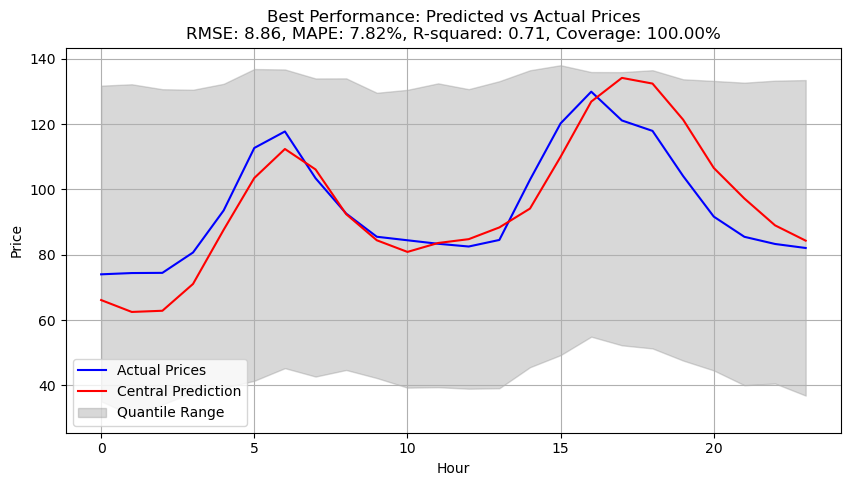

Worst Performance (Index: 164) - RMSE: 87.09, MAPE: 82.07%, R-squared: -20.60, Coverage: 79.17%


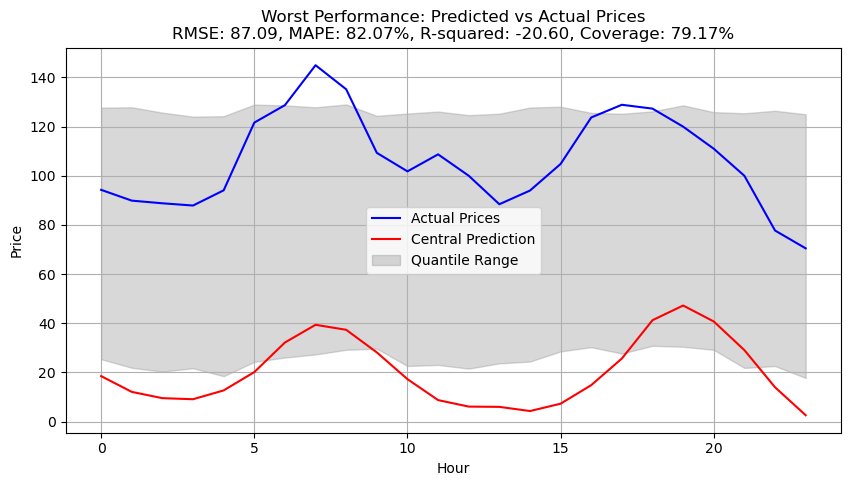

Median Performance (Index: 563) - RMSE: 24.17, MAPE: 27.81%, R-squared: -0.74, Coverage: 100.00%


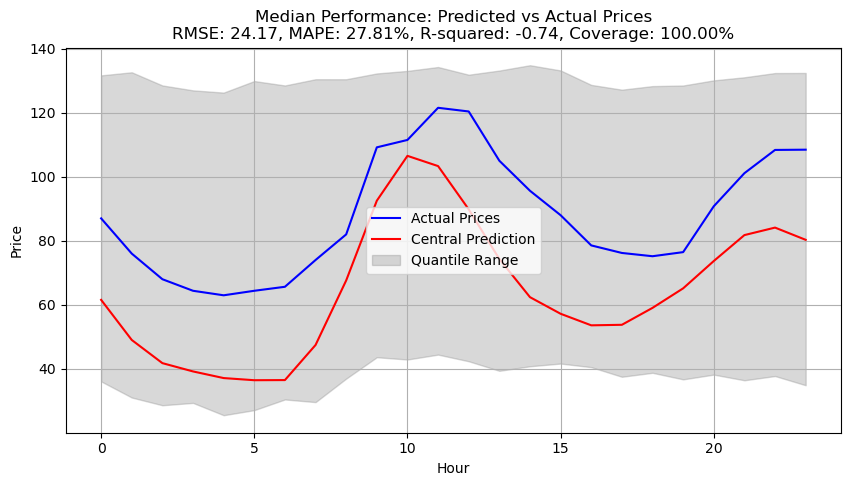


### Metrics Summary ###
Average RMSE: 33.98
Median RMSE: 24.13
Average MAPE: 43.60%
Median MAPE: 35.36%
Average R-squared: -3.34
Median R-squared: -0.50
Average Quantile Coverage: 89.90%
Median Quantile Coverage: 95.83%


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import torch

# Predict on test data
model.eval()
with torch.no_grad():
    central_preds, quantile_preds = model(X_test)  # Central prediction and quantile predictions

# Ensure quantile_preds is a tensor
if isinstance(quantile_preds, list):
    quantile_preds = torch.stack(quantile_preds, dim=1)  # Convert list to tensor [batch_size, num_quantiles, forecast_horizon]

# Inverse transform central predictions and actual values
central_preds_rescaled = scaler_target.inverse_transform(central_preds.cpu().numpy())  # Move to CPU before .numpy()
y_test_rescaled = scaler_target.inverse_transform(y_test.cpu().numpy())  # Move to CPU before .numpy()

# Inverse transform quantile predictions
quantile_preds_rescaled = np.stack([
    scaler_target.inverse_transform(quantile_preds[:, i, :].cpu().numpy())  # Move to CPU before .numpy()
    for i in range(quantile_preds.shape[1])  # Iterate over quantiles
], axis=1)  # Shape: [batch_size, num_quantiles, forecast_horizon]

# Metrics Calculation
rmse_per_sample = []
mape_per_sample = []
r2_per_sample = []
quantile_coverage = []

for actual, central_pred, quantile_pred in zip(y_test_rescaled, central_preds_rescaled, quantile_preds_rescaled):
    rmse_per_sample.append(np.sqrt(mean_squared_error(actual, central_pred)))
    mape_per_sample.append(np.mean(np.abs((actual - central_pred) / actual)) * 100)
    r2_per_sample.append(r2_score(actual, central_pred))
    
    # Quantile coverage
    lower_quantile = quantile_pred[0]  # Lower quantile (e.g., 10%)
    upper_quantile = quantile_pred[-1]  # Upper quantile (e.g., 90%)
    coverage = np.mean((actual >= lower_quantile) & (actual <= upper_quantile)) * 100
    quantile_coverage.append(coverage)

# Find indices for best, median, and worst performance based on RMSE
best_index = np.argmin(rmse_per_sample)
worst_index = np.argmax(rmse_per_sample)
median_index = np.argsort(rmse_per_sample)[len(rmse_per_sample) // 2]

# Function to visualize prediction, quantiles, and actual values
def plot_prediction_with_quantiles(index, title):
    actual = y_test_rescaled[index]
    central = central_preds_rescaled[index]
    lower_quantile = quantile_preds_rescaled[index, 0]  # Lower bound
    upper_quantile = quantile_preds_rescaled[index, -1]  # Upper bound
    rmse = np.sqrt(mean_squared_error(actual, central))
    mape = np.mean(np.abs((actual - central) / actual)) * 100
    r2 = r2_score(actual, central)
    coverage = np.mean((actual >= lower_quantile) & (actual <= upper_quantile)) * 100

    plt.figure(figsize=(10, 5))
    plt.plot(actual, label="Actual Prices", color="blue")
    plt.plot(central, label="Central Prediction", color="red")
    plt.fill_between(range(len(actual)), lower_quantile, upper_quantile, color="gray", alpha=0.3, label="Quantile Range")
    plt.title(f"{title}\nRMSE: {rmse:.2f}, MAPE: {mape:.2f}%, R-squared: {r2:.2f}, Coverage: {coverage:.2f}%")
    plt.xlabel("Hour")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize worst, best, and median performances
print("### Visualization of Predictions ###")
print(f"Best Performance (Index: {best_index}) - RMSE: {rmse_per_sample[best_index]:.2f}, "
      f"MAPE: {mape_per_sample[best_index]:.2f}%, R-squared: {r2_per_sample[best_index]:.2f}, "
      f"Coverage: {quantile_coverage[best_index]:.2f}%")
plot_prediction_with_quantiles(best_index, "Best Performance: Predicted vs Actual Prices")

print(f"Worst Performance (Index: {worst_index}) - RMSE: {rmse_per_sample[worst_index]:.2f}, "
      f"MAPE: {mape_per_sample[worst_index]:.2f}%, R-squared: {r2_per_sample[worst_index]:.2f}, "
      f"Coverage: {quantile_coverage[worst_index]:.2f}%")
plot_prediction_with_quantiles(worst_index, "Worst Performance: Predicted vs Actual Prices")

print(f"Median Performance (Index: {median_index}) - RMSE: {rmse_per_sample[median_index]:.2f}, "
      f"MAPE: {mape_per_sample[median_index]:.2f}%, R-squared: {r2_per_sample[median_index]:.2f}, "
      f"Coverage: {quantile_coverage[median_index]:.2f}%")
plot_prediction_with_quantiles(median_index, "Median Performance: Predicted vs Actual Prices")

# Summary statistics
print("\n### Metrics Summary ###")
print(f"Average RMSE: {np.mean(rmse_per_sample):.2f}")
print(f"Median RMSE: {np.median(rmse_per_sample):.2f}")
print(f"Average MAPE: {np.mean(mape_per_sample):.2f}%")
print(f"Median MAPE: {np.median(mape_per_sample):.2f}%")
print(f"Average R-squared: {np.mean(r2_per_sample):.2f}")
print(f"Median R-squared: {np.median(r2_per_sample):.2f}")
print(f"Average Quantile Coverage: {np.mean(quantile_coverage):.2f}%")
print(f"Median Quantile Coverage: {np.median(quantile_coverage):.2f}%")


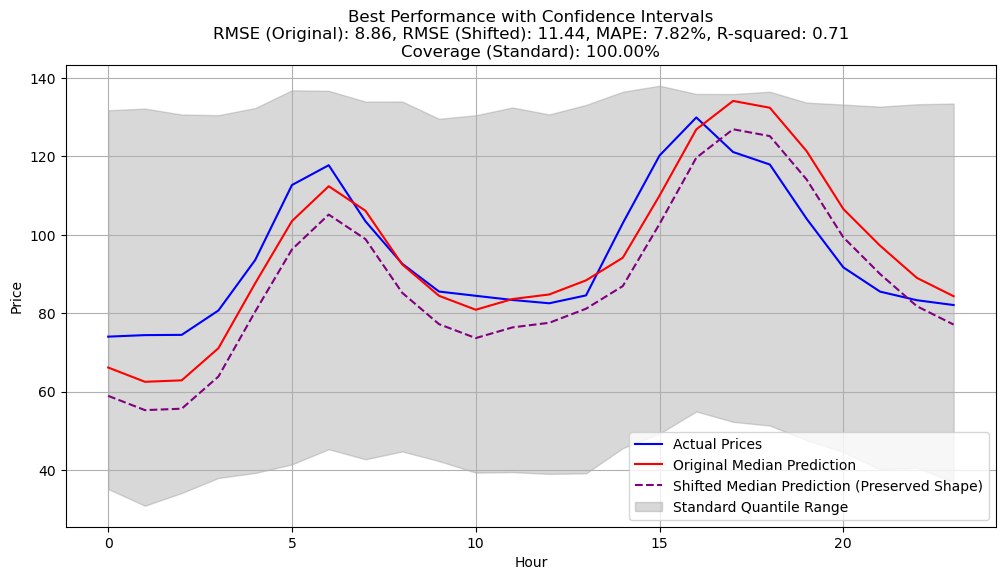

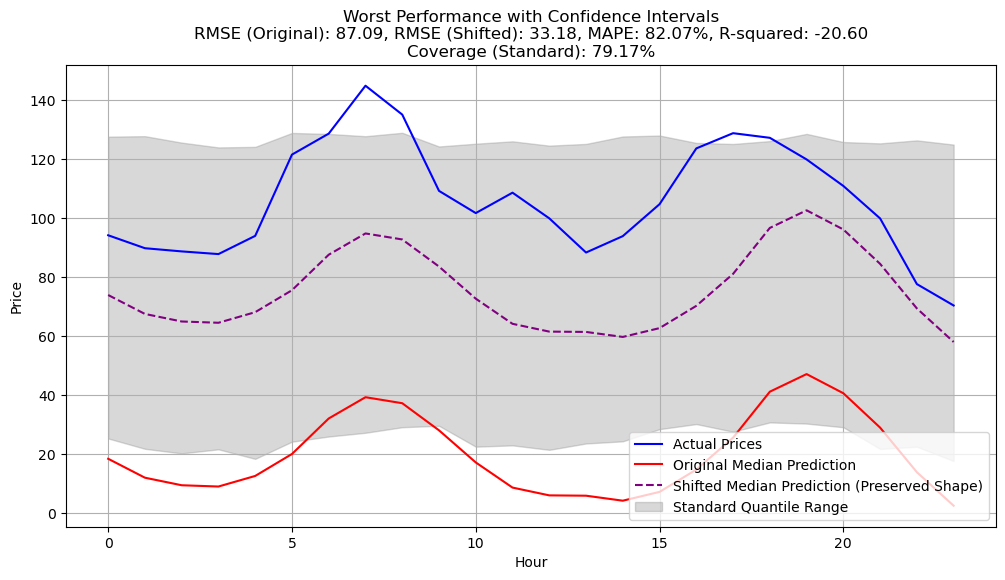

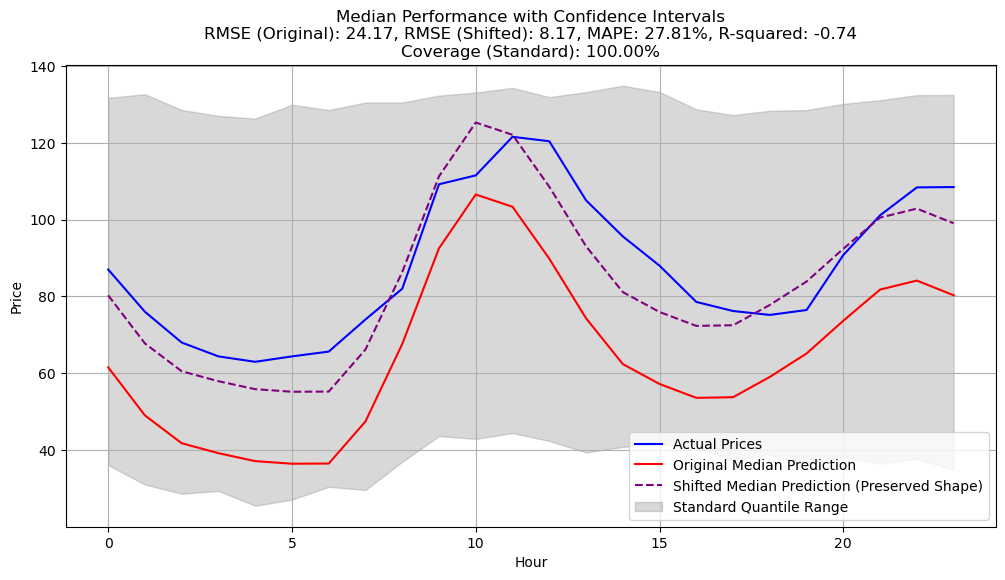

In [4]:
# Custom bounds calculation function
def calculate_custom_quantile_bounds(quantile_preds, desired_lower, desired_upper, original_quantiles):
    """
    Interpolates or approximates the quantile predictions for a desired confidence interval.

    Args:
        quantile_preds: Predicted quantiles [batch_size, num_quantiles, forecast_horizon].
        desired_lower: Desired lower quantile (e.g., 0.05 for 90% confidence interval).
        desired_upper: Desired upper quantile (e.g., 0.95 for 90% confidence interval).
        original_quantiles: List of quantiles the model was trained on.

    Returns:
        Interpolated lower and upper quantile bounds.
    """
    quantile_preds_np = quantile_preds.cpu().numpy()  # Convert tensor to numpy
    batch_size, num_quantiles, forecast_horizon = quantile_preds_np.shape

    lower_bound = np.zeros((batch_size, forecast_horizon))
    upper_bound = np.zeros((batch_size, forecast_horizon))

    for i in range(batch_size):
        for t in range(forecast_horizon):
            # Interpolate for each forecast horizon
            lower_bound[i, t] = np.interp(desired_lower, original_quantiles, quantile_preds_np[i, :, t])
            upper_bound[i, t] = np.interp(desired_upper, original_quantiles, quantile_preds_np[i, :, t])

    return lower_bound, upper_bound

def shift_median_to_center_preserve_shape(median, lower_bound, upper_bound):
    """
    Shift the median prediction to the center of the quantile range without altering its shape.
    
    Args:
        median: Median prediction [forecast_horizon].
        lower_bound: Lower quantile bound [forecast_horizon].
        upper_bound: Upper quantile bound [forecast_horizon].
    
    Returns:
        Shifted median prediction [forecast_horizon].
    """
    quantile_center = (lower_bound + upper_bound) / 2  # Center of the quantile range
    adjustment = np.mean(quantile_center - median)  # Calculate constant adjustment
    shifted_median = median + adjustment  # Apply constant adjustment
    return shifted_median




# Define confidence levels for comparison
original_quantiles = [0.1, 0.5, 0.9]  # Quantiles the model was trained on
desired_lower_90, desired_upper_90 = 0.05, 0.95  # For 90% confidence interval
desired_lower_50, desired_upper_50 = 0.25, 0.75  # For 50% confidence interval

# Calculate custom quantile bounds for desired confidence intervals
lower_90, upper_90 = calculate_custom_quantile_bounds(quantile_preds, desired_lower_90, desired_upper_90, original_quantiles)
lower_50, upper_50 = calculate_custom_quantile_bounds(quantile_preds, desired_lower_50, desired_upper_50, original_quantiles)

# Rescale custom bounds to match original value scale
lower_90_rescaled = scaler_target.inverse_transform(lower_90)
upper_90_rescaled = scaler_target.inverse_transform(upper_90)
lower_50_rescaled = scaler_target.inverse_transform(lower_50)
upper_50_rescaled = scaler_target.inverse_transform(upper_50)

# Visualization function with coverage calculation
def plot_prediction_with_correct_shifted_median(index, title):
    actual = y_test_rescaled[index]
    median = central_preds_rescaled[index]  # Median prediction is the central prediction
    
    # Standard quantile bounds
    lower_quantile_std = quantile_preds_rescaled[index, 0]  # Lower bound (standard)
    upper_quantile_std = quantile_preds_rescaled[index, -1]  # Upper bound (standard)
    
    # Shift median prediction to the center of the quantile range
    shifted_median = shift_median_to_center_preserve_shape(median, lower_quantile_std, upper_quantile_std)

    # Calculate coverage
    std_coverage = np.mean((actual >= lower_quantile_std) & (actual <= upper_quantile_std)) * 100

    # Calculate metrics
    rmse_original = np.sqrt(mean_squared_error(actual, median))
    rmse_shifted = np.sqrt(mean_squared_error(actual, shifted_median))
    mape = np.mean(np.abs((actual - median) / actual)) * 100
    r2 = r2_score(actual, median)

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label="Actual Prices", color="blue")
    plt.plot(median, label="Original Median Prediction", color="red")
    plt.plot(shifted_median, label="Shifted Median Prediction (Preserved Shape)", color="purple", linestyle="--")
    
    # Plot standard quantile bounds
    plt.fill_between(range(len(actual)), lower_quantile_std, upper_quantile_std, color="gray", alpha=0.3, label="Standard Quantile Range")
    
    plt.title(
        f"{title}\nRMSE (Original): {rmse_original:.2f}, RMSE (Shifted): {rmse_shifted:.2f}, "
        f"MAPE: {mape:.2f}%, R-squared: {r2:.2f}\n"
        f"Coverage (Standard): {std_coverage:.2f}%"
    )
    plt.xlabel("Hour")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the results
plot_prediction_with_correct_shifted_median(best_index, "Best Performance with Confidence Intervals")
plot_prediction_with_correct_shifted_median(worst_index, "Worst Performance with Confidence Intervals")
plot_prediction_with_correct_shifted_median(median_index, "Median Performance with Confidence Intervals")

